# Laser Energy
How much energy is needed to see lasers in our spectra?

In [29]:
%matplotlib widget
import numpy as np
import astropy.units as u
from astropy import constants as const
from astropy.table import Table
import matplotlib.pyplot as plt

In [30]:
import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})

In [3]:
# step 1: reproduce the calculation for Boyajian's Star with APF, Eqn 5 from:
# https://iopscience.iop.org/article/10.1088/1538-3873/aafe86/pdf

In [4]:
DeltaLam = 900*u.nm - 400*u.nm
pscale = 0.02 *u.nm / u.pixel
dlam = (3.26 * u.pixel) * pscale

D = 1470 * u.lightyear
d_t = 2.4 * u.m
Lambda = 500 *u.nm

# const.L_sun
# const.c * const.h / Lambda
A_d = np.pi * (1.2*u.m)**2

t_exp = 600 * u.second
et = 0.05 # efficiency

In [5]:
L_laser = 1.86 * D / (d_t**2) * np.sqrt(const.L_sun * dlam / DeltaLam * const.h * const.c * np.pi * (Lambda**3) / (A_d * t_exp * et))
L_laser.to('MW')
# this matches their calculation

<Quantity 24.05518632 MW>

In [6]:
# I dont understand that pixel scale for APF.... That doesn't give a resolution of R=lambda/delta lambda = 100k.
Lambda / dlam

<Quantity 7668.71165644>

In [7]:
pscale = 0.002 *u.nm / u.pixel
dlam = (3.26 * u.pixel) * pscale
Lambda / dlam
# closer!

<Quantity 76687.11656442>

In [8]:
# Zuckerman+2023 note this is wrong too! (their footnote #9)
# https://ui.adsabs.harvard.edu/abs/2023AJ....165..114Z
pscale = 0.002 *u.nm / u.pixel
dlam = (3.26 * u.pixel) * pscale

L_laser = 1.86 * D / (d_t**2) * np.sqrt(const.L_sun * dlam / DeltaLam * const.h * const.c * np.pi * (Lambda**3) / (A_d * t_exp * et))
L_laser.to('MW')

# This almost matches their correction (they say 7.3 MW, not 7.6 MW)

<Quantity 7.60691783 MW>

In [9]:
# The Zuckerman nearby star sample average:
D = 78.47 * u.lightyear
t_exp = 730 * u.second

L_laser = 1.86 * D / (d_t**2) * np.sqrt(const.L_sun * dlam / DeltaLam * const.h * const.c * np.pi * (Lambda**3) / (A_d * t_exp * et))
L_laser.to('kW')
# so this doesn't quite match Anna's result (84 kW). They use a slightly different equation, 
#  which integrates the line area in units of photons (they call this AMD). So I'll keep this larger
#  answer as usefully conservative.

#  This is comparable to lasers being developed by military
#  https://news.northropgrumman.com/news/releases/northrop-grumman-successfully-completes-preliminary-design-review-for-a-300-kilowatt-class-high-energy-laser

<Quantity 368.13680436 kW>

In [10]:
# need to reproduce Anna's energy calculation here, rather than just the Lipman. She uses 6x AMD, he uses 10x Sqrt(star)

# Constants in cgs units
h = 6.62607015e-27  # erg·s
c = 2.99792458e10   # cm/s
pi = np.pi

def zuckerman_eqn4(
    alpha,
    AMD,
    wavelength_A,
    distance_ly,
    exposure_time_s,
    num_observations,
    telescope_area_m2,
    transmitter_diameter_m,
    efficiency
):
    """
    Implements Equation (4) from Zuckerman et al. (2023, AJ 165, 114).
    Computes the minimum detectable laser luminosity (L_em) in erg/s.

    Parameters:
    - alpha: Detection threshold multiplier (e.g. 5 for 5-sigma)
    - AMD: Average Median Deviation of the residuals (photons)
    - wavelength_A: Laser wavelength in Angstroms (Å)
    - distance_ly: Distance to target in light-years
    - exposure_time_s: Exposure time per observation (s)
    - num_observations: Number of observations (N_obs)
    - telescope_area_m2: Collecting area of telescope (m²)
    - transmitter_diameter_m: Diameter of transmitting aperture (m)
    - efficiency: Throughput/efficiency (ε)

    Returns:
    - L_em: Minimum detectable laser luminosity in erg/s
    """
    # Convert units to cgs
    λ = wavelength_A * 1e-8  # Å to cm
    d_E = distance_ly * 9.461e17  # ly to cm
    A = telescope_area_m2 * 1e4  # m² to cm²
    d_T = transmitter_diameter_m * 100  # m to cm
    Δt = exposure_time_s
    N_obs = num_observations
    ε = efficiency

    numerator = (1.22**2) * alpha * pi * h * c * AMD * λ * d_E**2
    denominator = 4 * ε * Δt * N_obs * A * d_T**2

    L_em = numerator / denominator  # erg/s
    return L_em

L_em_test = zuckerman_eqn4(
    alpha=6,
    AMD=414.78,
    wavelength_A=5000,
    distance_ly=78.47,
    exposure_time_s=730,
    num_observations=1,
    telescope_area_m2=4.53,
    transmitter_diameter_m=2.5,
    efficiency=0.05
)

L_em_test / 1e10  # Convert erg/s to kilowatts (1e10 erg/s = 1 kW)


154.111711453911

In [11]:
# lets put a star at 100pc with high res data

D = (100*u.pc).to(u.lightyear)
t_exp = 7200 * u.second # 2 hours

L_laser = 1.86 * D / (d_t**2) * np.sqrt(const.L_sun * dlam / DeltaLam * const.h * const.c * np.pi * (Lambda**3) / (A_d * t_exp * et))
L_laser.to('kW')


<Quantity 487.22172216 kW>

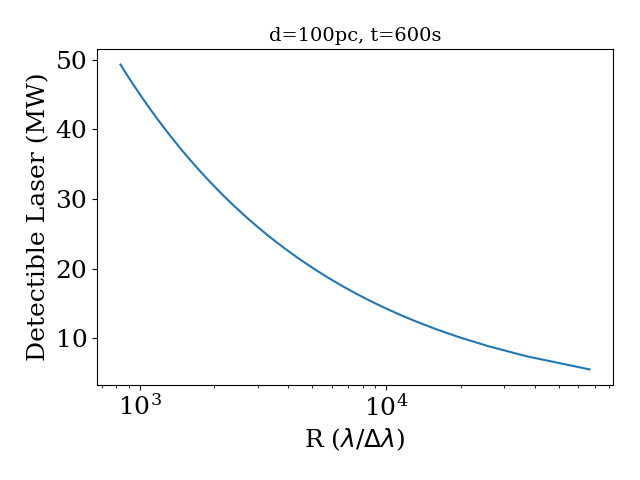

In [28]:
# how does resolution impact energy detection?

pscales = np.linspace(.025,2,100)
Lpowers = np.zeros_like(pscales)

for k in range(len(pscales)):
    DeltaLam = 1040*u.nm - 365*u.nm # for BOSS
    pscale = pscales[k] *u.angstrom / u.pixel # (need to check this)
    dlam = (3 * u.pixel) * pscale
    
    D = (100 * u.pc)
    d_t = 1.25 * u.m # assumed size of transmitter laser 
    Lambda = 500 *u.nm
    
    A_d = np.pi * (1.25*u.m)**2 # area of receiving telesocpe (SDSS)
    
    t_exp = 600 * u.second 
    et = 0.05 # efficiency
    L_laser = 1.86 * D / (d_t**2) * np.sqrt(const.L_sun * dlam / DeltaLam * const.h * const.c * np.pi * (Lambda**3) / (A_d * t_exp * et))
    Lpowers[k] = L_laser.to('MW').value


plt.figure()
plt.plot(Lambda.to('nm') / ((3*u.pixel * (pscales*u.angstrom/u.pixel)).to('nm')), Lpowers * u.MW)
plt.title('d=100pc, t=600s',fontsize=14)
plt.ylabel('Detectible Laser (MW)')
plt.xlabel('R ($\lambda/\Delta\lambda$)')
plt.xscale('log')
plt.tight_layout()
plt.savefig('Power_vs_R.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [13]:
Lambda.to('nm') / ((3*u.pixel * (pscales*u.angstrom/u.pixel)).to('nm'))[-10:]

<Quantity [915.52226384, 905.59824369, 895.88706393, 886.38195004,
           877.07641196, 867.96422935, 859.03943772, 850.29631538,
           841.72937125, 833.33333333]>

In [14]:
Lpowers[-10:]

array([47.04904592, 47.30613755, 47.56183952, 47.81617411, 48.06916304,
       48.32082743, 48.57118787, 48.82026444, 49.06807667, 49.31464363])

In [15]:
Lpowers[0:10]

array([ 5.51354477,  7.39304431,  8.88341334, 10.15740916, 11.28852909,
       12.31620142, 13.26449191, 14.14937009, 14.98207603, 15.77087602])

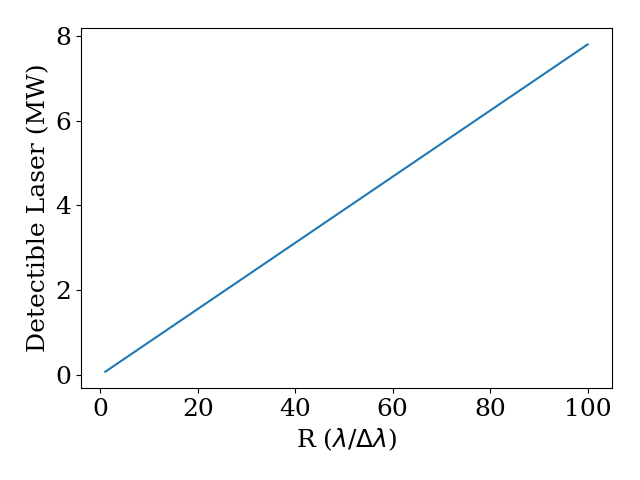

In [16]:
# how does distance impact power (should be easy)
# how does resolution impact energy detection?

dists = np.linspace(1,100,100)
Lpowers = np.zeros_like(pscales)

for k in range(len(pscales)):
    DeltaLam = 1040*u.nm - 365*u.nm # for BOSS
    pscale = 0.05 *u.angstrom / u.pixel # (need to check this)
    dlam = (3 * u.pixel) * pscale
    
    D = (dists[k] * u.pc)
    d_t = 1.25 * u.m # assumed size of transmitter laser 
    Lambda = 500 *u.nm
    
    A_d = np.pi * (1.25*u.m)**2 # area of receiving telesocpe (SDSS)
    
    t_exp = 600 * u.second 
    et = 0.05 # efficiency
    L_laser = 1.86 * D / (d_t**2) * np.sqrt(const.L_sun * dlam / DeltaLam * const.h * const.c * np.pi * (Lambda**3) / (A_d * t_exp * et))
    Lpowers[k] = L_laser.to('MW').value


plt.figure()
plt.plot(dists, Lpowers * u.MW)
# plt.title('d=100pc, t=600s',fontsize=14)
plt.ylabel('Detectible Laser (MW)')
plt.xlabel('Dist')
# plt.xscale('log')
plt.tight_layout()
# plt.savefig('Power_vs_R.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [17]:
def photons_from_diffraction_limited_laser(power_mw, distance_ly, wavelength_nm,
                                           exposure_time_s, telescope_diameter_m,
                                           transmitter_diameter_m, throughput=0.05):
    power_erg_s = power_mw * 1e13  # MW to erg/s
    distance_cm = distance_ly * 9.461e17  # ly to cm
    wavelength_cm = wavelength_nm * 1e-7  # nm to cm
    theta = 1.22 * wavelength_cm / (transmitter_diameter_m * 100)
    beam_area_cm2 = np.pi * (distance_cm * theta / 2)**2
    flux = power_erg_s / beam_area_cm2
    E_photon = (const.h.cgs * const.c.cgs / wavelength_cm)  # in erg
    photon_flux = flux / E_photon
    radius_cm = (telescope_diameter_m * 100) / 2
    area_cm2 = np.pi * radius_cm**2
    count_rate = photon_flux * area_cm2 * throughput
    total_counts = count_rate * exposure_time_s
    return total_counts.value


photons_from_diffraction_limited_laser(
        power_mw=24,
        distance_ly=1470,
        wavelength_nm=500,
        exposure_time_s=600,
        telescope_diameter_m=2.4,
        transmitter_diameter_m=2.4,
        throughput=0.05
    ) # reproducing Lipman+2019 calculation for Boyajian's Star

835.4150806923607

In [18]:
(1*u.MW).to(u.W)

<Quantity 1000000. W>

In [19]:
# lets think about the Psyche mission, a 4W laser at a few AU, 
# https://en.wikipedia.org/wiki/Deep_Space_Optical_Communications
photons_from_diffraction_limited_laser(
        power_mw=(4*u.W).to(u.MW).value,
        distance_ly=(2*u.AU).to(u.lightyear).value,
        wavelength_nm=1550,
        exposure_time_s=1,
        telescope_diameter_m=5., # P200in
        transmitter_diameter_m=0.22, # 22 cm
        throughput=0.05
    )

# laser_photon_counts(
#         power_mw=1,
#         distance_cm=5e13,  # about 4 AU
#         wavelength_A=5000,
#         resolution=50000,
#         exposure_time_s=7200,
#         telescope_diameter_m=1.2,
#         throughput=0.15)

5898637.585059332

In [20]:
(4*u.AU).to('cm')

<Quantity 5.98391483e+13 cm>

In [21]:
# Now lets "observe" Boyajian's Star with SDSS-like numbers

In [22]:
# DeltaLam = 920*u.nm - 380*u.nm # for SDSS original 
DeltaLam = 1040*u.nm - 365*u.nm # for BOSS
pscale = 1.02 *u.angstrom / u.pixel # (need to check this)
dlam = (3 * u.pixel) * pscale

D = 1470 * u.lightyear
d_t = 2.4 * u.m # assumed size of transmitter laser 
Lambda = 500 *u.nm

A_d = np.pi * (1.25*u.m)**2 # area of receiving telesocpe (SDSS)

t_exp = 2700 * u.second # assume basic 3x15min exposure for SDSS
et = 0.05 # efficiency

In [23]:
L_laser = 1.86 * D / (d_t**2) * np.sqrt(const.L_sun * dlam / DeltaLam * const.h * const.c * np.pi * (Lambda**3) / (A_d * t_exp * et))
L_laser.to('MW')

<Quantity 20.29755526 MW>

In [24]:
Lambda.to('nm') / dlam.to('nm')

<Quantity 1633.9869281>

In [25]:
# What about one of our normal targets, much further away?
D = 2000 * u.pc # Put star far away, at 2kpc

In [26]:
L_laser = 1.86 * D / (d_t**2) * np.sqrt(const.L_sun * dlam / DeltaLam * const.h * const.c * np.pi * (Lambda**3) / (A_d * t_exp * et))
L_laser.to('MW')

<Quantity 90.07043672 MW>

In [27]:
# Following calculation from Appendix in https://iopscience.iop.org/article/10.1088/1538-3873/aafe86/pdf
# how about the APOGEE laser energies?
DeltaLam = 16999*u.angstrom - 15100*u.angstrom # IR range for APOGEE

pscale = 0.22 * u.angstrom / u.pixel # from a random APOGEE spectrum
dlam = (2 * u.pixel) * pscale # need to check this against the LSF

D = 223 * u.pc # average dist to G dwarf in our APOGEE sample
d_t = 2.4 * u.m # assume aperture of transmitting telescope is 2.4m
Lambda = 16100 *u.angstrom # need the laser line to be in the IR

A_d = np.pi * (1.25*u.m)**2 # radius of SDSS telescope primary mirror

t_exp = 5*800 * u.second # APOGEE = 5x800second exposure stacks
# https://www.sdss4.org/dr17/irspec/apogee-observing/#:~:text=A%20standard%20exposure%20sequence%20is,or%20six%201000%20second%20exposures.

et = 0.05 # 5% efficiency.... seems OK

L_laser = 1.86 * D / (d_t**2) * np.sqrt(const.L_sun * dlam / DeltaLam * const.h * const.c * np.pi * (Lambda**3) / (A_d * t_exp * et))
L_laser.to('MW')

<Quantity 34.08378828 MW>

In [49]:
def _gaus(x, a, b, x0, sigma):
    """
    Define a simple Gaussian curve

    Could maybe be swapped out for astropy.modeling.models.Gaussian1D

    Parameters
    ----------
    x : float or 1-d numpy array
        The data to evaluate the Gaussian over
    a : float
        the amplitude
    b : float
        the constant offset
    x0 : float
        the center of the Gaussian
    sigma : float
        the width of the Gaussian

    Returns
    -------
    Array or float of same type as input (x).
    """
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2)) + b

In [39]:
# https://cdsarc.cds.unistra.fr/ftp/J/A+A/681/A107/spectra_sample/
mel = Table.read('327514_melchiors_spectrum.fits', format='fits')
mel

wave_log,wave,flux_norm,err_norm,flux_tac,err_tac,flux_irc,err_irc,flux_raw,err_raw
,Angstrom,,,,,,,,
float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
8.233276,3764.1477,--,--,--,--,--,--,-1.5539696,3.4684858
8.233282,3764.1675,--,--,--,--,--,--,-1.7240509,3.0471387
8.233287,3764.187,--,--,--,--,--,--,1.4678147,2.4191387
8.233293,3764.2065,--,--,--,--,--,--,-1.6569262,2.3612876
8.233297,3764.226,--,--,--,--,--,--,-2.8067849,2.5404258
8.233303,3764.2456,1.0032713,0.41956967,0.7942092,0.33213955,0.7936343,0.33189914,3.9813561,2.9028106
8.233308,3764.2654,1.6699516,0.5261586,1.321699,0.41643322,1.3207397,0.41613096,6.626661,3.6400244
8.233314,3764.285,0.29745436,0.4747415,0.23537575,0.3756631,0.23520459,0.37539002,1.1802913,3.2841094


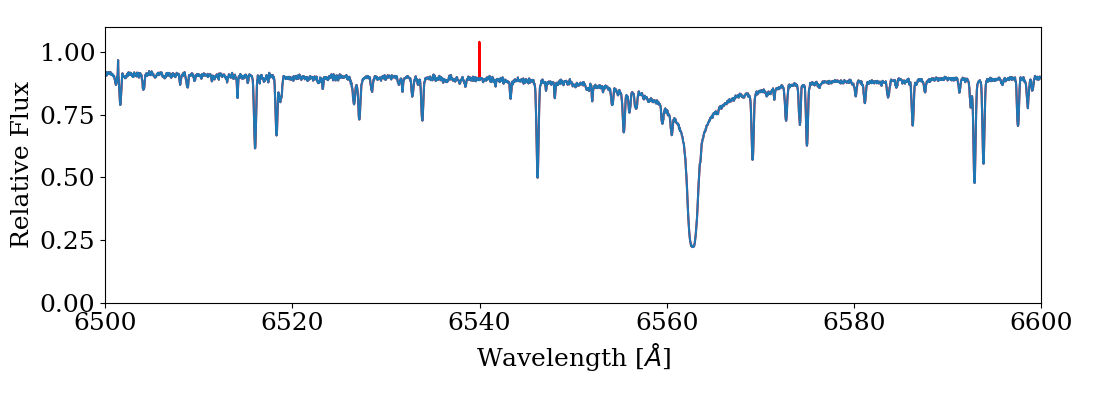

In [66]:

plt.figure(figsize=(11,4))
plt.plot(mel['wave'], mel['flux_irc']+ _gaus(mel['wave'].value, 0.2, 0, 6540, 0.02), c='r')
plt.plot(mel['wave'], mel['flux_irc'])
plt.xlim(6500,6600)
plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Relative Flux')
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig('line_example.png', dpi=150, bbox_inches='tight', pad_inches=0.25)

In [50]:
mel['wave'].value

array([3764.1477, 3764.1675, 3764.187 , ..., 9004.357 , 9004.404 ,
       9004.451 ], dtype='>f4')